In [1]:
"""
@author: pho
"""
%config Completer.use_jedi = False
## Automatic debugger on exception raised
# %pdb on
%pdb off
%load_ext autoreload
%autoreload 2
# # You need to load the extension first
# %load_ext viztracer

import sys
import importlib
from pathlib import Path
import logging

# from pyphocorehelpers.print_helpers import build_module_logger
# module_logger = build_module_logger('Spike3D.notebook')

from copy import deepcopy

from numba import jit
import numpy as np
import pandas as pd

# required to enable non-blocking interaction:
%gui qt5

import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to plot Speed vs. Pf Desnity Metrics
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui, QtWidgets
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion, get_arguments_as_optional_dict, inspect_callable_arguments, safely_accepts_kwargs
from pyphocorehelpers.indexing_helpers import partition, compute_spanning_bins, interleave_elements, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter, print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
# from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from neuropy.core.session.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable import LocalMenus_AddRenderable
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateLinkedWidget_MenuProvider import CreateLinkedWidget_MenuProvider

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters

from neuropy.core.laps import Laps  # Used for adding laps in KDiba mode
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping # Used for adding laps in KDiba mode

from neuropy.core.epoch import NamedTimerange

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# np.set_string_function(None, repr=True)
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData, saveData

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer, override_dict, overriding_dict_with, get_dict_subset
from neuropy.utils.position_util import compute_position_grid_size

## Test Matplotlib plotting:
from neuropy.utils.matplotlib_helpers import _build_variable_max_value_label, add_inner_title, enumTuningMap2DPlotMode, _build_square_checkerboard_image, enumTuningMap2DPlotVariables, compute_data_aspect_ratio

def build_eloy_computation_configs(sess, **kwargs):
    """ OPTIONALLY can be overriden by implementors to provide specific filter functions """
    # (4.0, 4.0)cm bins, (6.0, 6.0)cm gaussian smoothing
    # peak frate > 2Hz 
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(6.0, 6.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(2.5, 2.5), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=0.025, computation_epochs = None), spike_analysis=None)]

Automatic pdb calling has been turned OFF


/Users/pho/mambaforge/envs/viz3d/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/pho/mambaforge/envs/viz3d/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
objc[24003]: Class QMacAutoReleasePoolTracker is implemented in both /Users/pho/mambaforge/envs/viz3d/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x180316198) and /Users/pho/mambaforge/envs/viz3d/lib/libQt5Core.5.12.9.dylib (0x196fd4528). One of the two will be used. Which one is undefined.
objc[24003]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both

build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL/TESTING/Logging/debug_com.PhoHale.Spike3D.pipeline.log


# Load Appropriate Data and begin pipeline

## Bapun Format:

In [ ]:
active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
# basedir = r'R:\data\Bapun\RatS\Day5TwoNovel'
basedir = r'W:\Data\Bapun\RatS\Day5TwoNovel'
# basedir = r'/home/halechr/Data/Bapun/RatS/Day5TwoNovel'

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), force_reload=False) # damn this file is 21.1 GB!
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0],
                                          computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_position_decoding_computation', '_perform_two_step_position_decoding_computation'],
                                          # computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'],
                                          overwrite_extant_results=False) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'Data/Output', should_smooth_maze=False) # TODO: pass a display config
                                      
## _perform_velocity_vs_pf_density_computation: causes AssertionError: After AOC normalization the sum over each cell should be 1.0, but it is not! [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] with 1D placefields!

### Test arbitrary filtering beyond active_session_filter_configurations:

In [ ]:
# import sys # required for sys.float_info.min
from copy import deepcopy
# from neuropy.core.epoch import NamedTimerange # Custom rippleOnly filters:

## Adds the custom ComputationConfig with .pf_params.computation_epochs set to the ripple epochs only:
dup_ripple_only_computation_config = deepcopy(active_session_computation_configs[0]) # make a deepcopy of the active computation config
dup_ripple_only_computation_config.pf_params.computation_epochs = curr_active_pipeline.sess.ripple # set the computation epochs for the copy to the ripple epochs only
# dup_ripple_only_computation_config.pf_params.speed_thresh = sys.float_info.min # no speed thresholding because we're wanting to look at the ripples
dup_ripple_only_computation_config.pf_params.speed_thresh = 0.0 # no speed thresholding because we're wanting to look at the ripples
active_session_computation_configs.append(dup_ripple_only_computation_config)
# active_session_filter_configurations['maze1_rippleOnly'] = lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze1_rippleOnly', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze1_rippleOnly', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
active_session_filter_configurations['maze1_rippleOnly'] = deepcopy(active_session_filter_configurations['maze1']) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK
active_session_filter_configurations['maze2_rippleOnly'] = deepcopy(active_session_filter_configurations['maze2']) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK

# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[1], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'], fail_on_exception=False) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=False) # TODO: pass a display config

In [ ]:
# Loops through all the configs and ensure that they have the neuron identity info if they need it.
curr_active_pipeline.perform_drop_computed_items(config_names_to_drop = ['maze1_rippleOnly', 'maze2_rippleOnly'])


In [ ]:
## Test fixing broken/invalid paths for plotting_config:
debug_print = True

for _temp_curr_config_name in ['maze1_rippleOnly', 'maze2_rippleOnly']:
    active_config = curr_active_pipeline.active_configs[_temp_curr_config_name]# InteractivePlaceCellConfig
    # active_config
    if debug_print:
        print(f'_display_custom_user_function(computation_result, active_config, **kwargs):')
    active_session_name = active_config.active_session_config.session_name
    if debug_print:
        print(f'active_session_name: {active_session_name}')
    active_epoch_names = active_config.active_epochs
    if debug_print:
        print(f'active_epoch_names.name: {active_epoch_names.name}') # active_epoch_names: <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
    # active_epoch_names.name: maze1
    _curr_safe_out_path = Path('output', active_session_name, _temp_curr_config_name)
    curr_active_pipeline.active_configs[_temp_curr_config_name].plotting_config.change_active_out_parent_dir(new_parent=_curr_safe_out_path) # active_epoch_names.name
    curr_active_pipeline.active_configs[_temp_curr_config_name].plotting_config.active_output_parent_dir = _curr_safe_out_path
    # self.active_output_parent_dir
    print(f"for {_temp_curr_config_name} - {curr_active_pipeline.active_configs[_temp_curr_config_name].plotting_config.get_figure_save_path('test')}")
    
    # self.active_configs[an_active_config_name]
## Completely invalid path
# active_config.plotting_config.active_output_parent_dir # WindowsPath('W:/Data/Output/2022-09-13/RatS-Day5TwoNovel-2020-12-04_07-55-09/maze1/speedThresh_0.00-gridBin_2.74-smooth_2.00-frateThresh_0.20-time_bin_size_1.00-computation_epochs_13811 epochs\narray([[1.6712, 1.7736],\n       [2.0536, 2.1744],\n       [4.9616, 5.3448],\n       ...,\n       [42274, 42274.2],\n       [42276.1, 42276.3],\n       [42298, 42298.1]])\n')


In [ ]:
out_figure_save_original_root = active_config.plotting_config.get_figure_save_path('test') # 2022-01-16/
out_figure_save_original_root
# active_config.plotting_config = _set_figure_save_root_day_computed_mode(active_config.plotting_config, active_session_name, active_epoch_names.name, root_output_dir=root_output_dir, debug_print=debug_print)

In [ ]:
curr_config.plotting_config.get_figure_save_path('test')
# active_session_filter_configurations['maze2_rippleOnly']# = deepcopy(active_session_filter_configurations['maze2']) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK
#PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', computation_result.sess.config.session_name, 'custom_laps'))

In [ ]:
# %pdb on

curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=False) # TODO: pass a display config

In [ ]:
active_session_computation_configs.time

### Bapun Open-Field Experiment (2022-08-09 Analysis)

In [ ]:
from neuropy.core.session.SessionSelectionAndFiltering import build_custom_epochs_filters # used particularly to build Bapun-style filters

active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'W:\Data\Bapun\RatN\Day4OpenField' # Apogee
# basedir = '/Volumes/MoverNew/data/Bapun/RatN/Day4OpenField' # mac

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), force_reload=False)
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess, included_epoch_names=['maze','sprinkle']) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, included_epoch_labels=['maze','sprinkle'])
active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, included_epoch_labels=['maze','sprinkle'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(curr_active_pipeline.sess, included_epoch_labels=['maze','sprinkle'])
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=1.0)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_recursive_latent_placefield_decoding', '_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config
curr_active_pipeline.save_pipeline()

## Rachel Format:

In [ ]:
active_data_mode_name = 'rachel'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'R:\data\Rachel\merged_M1_20211123_raw_phy' # Windows

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation']) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

## KDiba Format:

In [2]:
# %%viztracer
active_data_mode_name = 'kdiba'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

## Animal `gor01`:
# local_session_parent_path = Path(r'W:\Data\KDIBA\gor01\one') # Apogee Windows (W: Wiser)
# local_session_parent_path = Path(r'R:\data\KDIBA\gor01\one') # Apogee Windows (R: MoverNew)
local_session_parent_path = Path(r'/Volumes/MoverNew/data/KDIBA/gor01/one') # Pho's MacBook Pro
# local_session_parent_path = Path(r'/run/media/halechr/MoverNew/data/KDIBA/gor01/one') # Lab Linux Workstation (with external MoverNew drive)
# local_session_parent_path = Path(r'/home/halechr/Data/KDIBA/gor01/one') # Lab Linux Workstation (local user folder Data)

local_session_names_list = ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']


# ### Animal `vvp01`:
# local_session_parent_path = Path(r'W:\Data\KDIBA\vvp01') # Apogee Windows (W: Wiser)

# local_session_names_list = ['2006-4-09_17-29-30',
#                             # '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6'
#                            ]

local_session_paths_list = [local_session_parent_path.joinpath(a_name).resolve() for a_name in local_session_names_list]
basedir = local_session_paths_list[1] # NOT 3
print(f'basedir: {str(basedir)}')

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), override_post_load_functions=[], force_reload=True, active_pickle_filename='loadedSessPickle.pkl', skip_save=True)
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze','maze1','maze2'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1','maze2'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze2'])

# sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
# 'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
# 'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
#                 }

active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=0.03333) #1.0/30.0 # decode at 30fps to match the position sampling frequency
# active_session_computation_configs[0].pf_params.smooth = (0.0, 0.0)
# active_session_computation_configs = build_eloy_computation_configs(sess=curr_active_pipeline.sess)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

# Whitelist Mode:
computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        # '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                     ]  # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'
computation_functions_name_blacklist=None

# # Blacklist Mode:
# computation_functions_name_whitelist=None
# computation_functions_name_blacklist=['_perform_spike_burst_detection_computation','_perform_recursive_latent_placefield_decoding']

curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_whitelist=computation_functions_name_whitelist, computation_functions_name_blacklist=computation_functions_name_blacklist, fail_on_exception=True, debug_print=False) #, overwrite_extant_results=False  ], fail_on_exception=True, debug_print=False)

# curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation'], debug_print=False, fail_on_exception=False) # whitelist: ['_perform_baseline_placefield_computation']
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config

basedir: /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15
Skipping loading from pickled file because force_reload == True.
Must reload/rebuild.
NeuropyPipeline.on_stage_changed(new_stage="PipelineStage.Input")
Loading matlab import file results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.epochs_info.mat... done.
Loading matlab import file results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.position_info.mat... done.
Loading matlab import file results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.spikes.mat... 

/Users/pho/repo/Python Projects/NeuroPy/neuropy/core/session/Formats/SessionSpecifications.py:139: UserWarning: WARNING: Optional File: /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.dat does not exist. Continuing without it.
  warnings.warn(f'WARNING: Optional File: {an_optional_filepath} does not exist. Continuing without it.')


done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.position.npy... 2006-6-08_14-26-15.position.npy saved
done.
	 force_recompute is True! Forcing recomputation of .interpolated_spike_positions.npy

Computing interpolate_spike_positions columns results to spikes_df... done.
	 Saving updated interpolated spike position results results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.interpolated_spike_positions.npy... 2006-6-08_14-26-15.interpolated_spike_positions.npy saved
done.
Loading matlab import file results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08_14-26-15.laps_info.mat... done.
setting laps object.
session.laps loaded successfully!
Loading matlab import file results to /Volumes/MoverNew/data/KDIBA/gor01/one/2006-6-08_14-26-15/2006-6-08

In [3]:
curr_active_pipeline

In [4]:
import dill as pickle

In [ ]:
curr_active_pipeline.save_pipeline()

## Hiro Format:

In [ ]:
active_data_mode_name = 'hiro'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
## For data located at:
# W:\Data\Rotation_3_Kamran Diba Lab\DataProcessingProject\Hiro_Datasets

## Data must be pre-processed using the MATLAB script located here: 
#     ./neuropy/data_session_pre_processing_scripts/HIRO/PhoDibaProcess_ComputeSingleExperiment.m
## ALT: alternatively, the original files are located here:
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\PhoDibaProcess_ComputeSingleExperiment.m
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\DEVELOPMENT\NeuroPyExporting2022\PhoNeuroPyConvert_ExportAllToPython_MAIN.m

# From pre-computed .mat files:
## RoyMaze1: 
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze1' # WINDOWS (R: MoverNew)
basedir = r'W:\Data\Hiro\RoyMaze1' # Apogee Windows (W: Wiser)

## RoyMaze2:
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze2' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze2' # WINDOWS
curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))

In [ ]:
from neuropy.utils.misc import convert_dataframe_columns_to_datatype_if_possible, add_explicit_dataframe_columns_from_lookup_df

## Finish setting up the spikes_df:
curr_active_pipeline.sess.spikes_df.spikes.set_time_variable_name("t_seconds")
curr_active_pipeline.sess.flattened_spiketrains._spikes_df = add_explicit_dataframe_columns_from_lookup_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.neurons._extended_neuron_properties_df).sort_values(by=['t_seconds']) # Need to re-sort by timestamps once done
convert_dataframe_columns_to_datatype_if_possible(curr_active_pipeline.sess.spikes_df, {'int':['shank', 'cluster', 'aclu', 'qclu', 'traj', 'lap']})

In [ ]:
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = active_data_mode_registered_class.build_track_only_filter_functions(sess=curr_active_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_track_only_pyramidal(sess=curr_active_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
# active_session_computation_configs

In [ ]:
post_filter_fn = active_session_filter_configurations['track']


active_session_filter_configurations['track'] = lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1'))

In [ ]:
curr_active_pipeline.sess.flattened_spiketrains._time_variable_name

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

In [ ]:
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'], fail_on_exception=True)
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

In [ ]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_spikes_df_column_info

In [ ]:
# curr_active_pipeline.sess.spikes_df.columns
# curr_active_pipeline.sess.spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.sess.spikes_df)

In [ ]:
# curr_active_pipeline.filtered_sessions['track'].spikes_df.columns
# curr_active_pipeline.filtered_sessions['track'].spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.filtered_sessions['track'].spikes_df)

In [ ]:
curr_active_pipeline.sess.neurons._extended_neuron_properties_df

## 💾 Save out the changes to the pipeline after computation to the pickle file for easy loading in the future:

In [ ]:
curr_active_pipeline.pickle_path

In [ ]:
curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle-2022-10-22.pkl')

In [ ]:
curr_active_pipeline.save_pipeline()

# Common: Multiple Context Explorations

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.ProgrammaticPipelineWidget.ProgrammaticPipelineWidget import ProgrammaticPipelineWidget
widget = ProgrammaticPipelineWidget(owning_pipeline=curr_active_pipeline)
widget.show()
widget

In [ ]:
# spike_raster_plt_2d, spike_raster_plt_3d, spike_raster_window = widget.last_added_display_output['spike_raster_plt_2d'], widget.last_added_display_output['spike_raster_plt_3d'], widget.last_added_display_output['spike_raster_window'] # Extract variables from the `target_dict` dictionary to the local workspace
spike_raster_window = widget.last_added_display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
ipcDataExplorer = widget.last_added_display_output['ipcDataExplorer']
pActiveSpikesBehaviorPlotter = widget.last_added_display_output['plotter']

In [ ]:
active_2d_plot.clear_all_rendered_intervals()

In [ ]:
active_2d_plot.unit_sort_order

In [ ]:
def Action1():
    print('You selected Action 1')

def Action2():
    print('You selected Action 2')

menu = QtGui.QMenu()
menu.addAction('This is Action 1', Action1)
menu.addAction('This is Action 2', Action2)
spike_raster_window.ui.bottomPlaybackControlBarWidget.ui.btnCurrentIntervals_Customize.setMenu(menu)

In [ ]:
spike_raster_window.ui.bottomPlaybackControlBarWidget.current_selected_jump_target_series_name

In [ ]:
active_2d_plot.remove_rendered_intervals(name=spike_raster_window.ui.bottomPlaybackControlBarWidget.current_selected_jump_target_series_name)

In [ ]:
active_2d_plot.list_all_rendered_intervals()

In [ ]:
long_only_aclus

In [ ]:
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

In [ ]:
is_spike_included = active_2d_plot.spikes_df.aclu.to_numpy() == 4
active_2d_plot.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
# Deemphasize all those cells except the long_only cells
is_spike_included = np.isin(active_2d_plot.spikes_df.aclu.to_numpy(), long_only_aclus)
active_2d_plot.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
# Deemphasize all those cells except the short_only cells
is_spike_included = np.isin(active_2d_plot.spikes_df.aclu.to_numpy(), short_only_aclus)
active_2d_plot.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
active_2d_plot.reset_spike_emphasis()

In [ ]:
active_2d_plot

In [ ]:
spike_raster_window

Traceback (most recent call last):
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/GUI/Qt/Widgets/ProgrammaticPipelineWidget/ProgrammaticPipelineWidget.py", line 195, in <lambda>
    _newToolFunction = lambda isChecked, bound_function_name=function_name: self._perform_run_display_function(bound_function_name)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/GUI/Qt/Widgets/ProgrammaticPipelineWidget/ProgrammaticPipelineWidget.py", line 207, in _perform_run_display_function
    display_outputs = self.owning_pipeline.display(curr_display_fcn, self.ui.contextSelectorWidget.current_selected_context, **custom_args)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/General/Pipeline/Stages/Display.py", line 324, in display
    curr_display_output = display_function(self.computation_results[active_session_configuration_name], self.active_configs[active_session_configuration_name], owning_pipeline=self, active_config_name=active_session_configuration_name, **kwargs)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/General/Pipeline/Stages/DisplayFunctions/DecoderPredictionError.py", line 234, in _display_plot_decoded_epoch_slices
    filter_epochs_decoder_result = active_decoder.decode_specific_epochs(computation_result.sess.spikes_df, filter_epochs=active_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Analysis/Decoder/reconstruction.py", line 786, in decode_specific_epochs
    return self.perform_decode_specific_epochs(self, spikes_df=spikes_df, filter_epochs=filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=debug_print)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Analysis/Decoder/reconstruction.py", line 860, in perform_decode_specific_epochs
    spkcount, nbins, time_bin_containers_list = epochs_spkcount(filter_epoch_spikes_df, filter_epochs, decoding_time_bin_size, slideby=decoding_time_bin_size, export_time_bins=True, included_neuron_ids=active_decoder.neuron_IDs, debug_print=debug_print) ## time_bins returned are not correct, they're subsampled at a rate of 1000
  File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/analyses/decoders.py", line 119, in epochs_spkcount
    bin_container = BinningContainer(edges=reduced_time_bin_edges)
  File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/utils/mixins/binning_helpers.py", line 67, in __init__
    self.center_info = BinningContainer.build_center_binning_info(self.centers, self.edge_info.variable_extents)
  File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/utils/mixins/binning_helpers.py", line 80, in build_center_binning_info
    actual_window_size = centers[2] - centers[1]
IndexError: index 2 is out of bounds for axis 0 with size 2

# Common: Single Context(Session, Filter) - active_identifying_filtered_session_ctx
Acts on a single specific filter `active_config_name`. Everything below this line will require a valid `active_config_name` to be set.

In [ ]:
# %%viztracer

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

## MATPLOTLIB Imports:
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')
# backend_qt5agg
# matplotlib.use('AGG') # non-interactive backend
## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!
import matplotlib.pyplot as plt
import matplotlib as mpl
from neuropy.utils.matplotlib_helpers import enumTuningMap2DPlotVariables # for getting the variant name from the dict
_bak_rcParams = mpl.rcParams.copy()
mpl.rcParams['toolbar'] = 'None' # disable toolbars

debug_print = False
# print(f'curr_active_pipeline.filtered_contexts: {curr_active_pipeline.filtered_contexts}')
# print(f'curr_active_pipeline.display_output: {curr_active_pipeline.display_output}')

# ## Old way:
# # Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18) 
# out_items = {}
# master_dock_win, app, out_items = context_nested_docks(curr_active_pipeline, enable_gui=False, debug_print=True)


### 🟢✅ SETTING THE ACTIVE CONFIG NAME:

# active_config_name = 'maze1'
# active_config_name = 'maze2'
# active_config_name = 'maze'
# active_config_name = 'sprinkle'

# active_config_name = 'maze_PYR'

# active_config_name = 'maze1_rippleOnly'
# active_config_name = 'maze2_rippleOnly'

# active_config_name = curr_active_pipeline.active_config_names[0] # get the first name by default
active_config_name = curr_active_pipeline.active_config_names[-1] # get the last name
print(f'active_config_name: {active_config_name}')

## Add the filter to the active context
# active_identifying_filtered_session_ctx = active_identifying_session_ctx.adding_context('filter', filter_name=active_config_name) # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'
active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts[active_config_name] # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
print(f'active_computed_data.keys(): {list(active_computed_data.keys())}')
print(f'active_computation_errors: {active_computation_errors}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data.get('firing_rate_trends', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_recursive_latent_pf_1Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_RecursiveLatent', None) # list
active_recursive_latent_pf_2Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_RecursiveLatent', None) # list

active_extended_stats = curr_active_pipeline.computation_results[active_config_name].computed_data.get('extended_stats', None)
active_eloy_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('EloyAnalysis', None)
active_simpler_pf_densities_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('SimplerNeuronMeetingThresholdFiringAnalysis', None)
active_ratemap_peaks_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', None)
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

active_display_output = curr_active_pipeline.display_output[active_identifying_filtered_session_ctx]
print(f'active_display_output: {active_display_output}')

# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)
display_output = active_display_output | curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=False, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

def _get_curr_figure_format_config():
    """ Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
    Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
    """
    ## Get the figure_format_config from the figure_format_config widget:
    # Fetch the context from the GUI:
    _curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
    _curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
    if _curr_gui_figure_format_config_widget is not None:
        # has GUI for config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    else:
        # has non-GUI provider of figure_format_config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    
    if debug_print:
        print(f'recovered gui figure_format_config: {figure_format_config}')
        
    return figure_format_config

figure_format_config = _get_curr_figure_format_config()

## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import build_pdf_export_metadata

filter_name = active_config_name
_build_pdf_pages_output_info, programmatic_display_function_testing_output_parent_path = build_pdf_export_metadata(curr_active_pipeline.sess.get_description(), filter_name=filter_name)
print(f'Figure Output path: {str(programmatic_display_function_testing_output_parent_path)}')

In [ ]:
# active_computation_results[filter_name]
active_firing_rate_trends = active_computed_data['firing_rate_trends']
list(active_firing_rate_trends.keys()) # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

active_firing_rate_trends.all_session_spikes['instantaneous_unit_specific_spike_rate'] = None #['instantaneous_unit_specific_spike_rate']

In [ ]:
active_extended_stats.

In [ ]:
 # plot_data = pd.DataFrame({'t': curr_sess.mua.time, 'mua_firing_rate': curr_sess.mua.firing_rate, 'mua_spike_counts': curr_sess.mua.spike_counts})
plot_data = pd.DataFrame({'t': sess.mua.time, 'mua_firing_rate': sess.mua.firing_rate})
active_3d_plot.add_3D_time_curves(plot_dataframe=plot_data)
# active_3d_plot.add_3D_time_curves(plot_data)

### Plots for each (session, filter):
🔜 NEXT STEP: TODO: 2022-08-10 - Got the ratemaps plotting working for all filters and those combined into a single window (with items docked) using `_build_docked_pf_2D_figures_widget`. Now need to add more plots, like the `DecoderPlotSelectorWidget`

In [ ]:
from PendingNotebookCode import spike_count_and_firing_rate_normalizations

# pho_custom_decoder = curr_active_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
pho_custom_decoder = active_computed_data['pf2D_Decoder']
enable_plots = True

print(f'most_likely_positions: {np.shape(pho_custom_decoder.most_likely_positions)}') # most_likely_positions: (3434, 2)
unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:

# pho_custom_decoder.unit_specific_time_binned_spike_counts.shape # (64, 1717)
unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_var = np.nanvar(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_median = np.nanmedian(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)

unit_specific_binned_spike_count_mean
unit_specific_binned_spike_count_median

## 🚧🟨🔜 TODO 2022-08-18: refactor curr_active_pipeline.display(...) to take a IdentifyingContext instead of the inputs it currently takes

In [ ]:
# @capture_new_figures_decorator
def _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name, debug_print=True):
    """ Implicitly captures out_items, `active_identifying_filtered_session_ctx` """
    ## Add the filter to the active context
    active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='_display_2d_placefield_result_plot_ratemaps_2D')

    # Fetch the context from the GUI:
    figure_format_config = _get_curr_figure_format_config()
    
    active_filter_pf_2D_figures = {}
    active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.TUNING_MAPS)
    active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
    if debug_print:
        print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')
    
    active_filter_pf_2D_figures['TUNING_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=active_identifying_ctx_string, **figure_format_config)[0]
    return active_filter_pf_2D_figures

active_pf_2D_figures = {}
active_pf_2D_figures[active_config_name] = _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name=active_config_name)

# active_pf_2D_figures
# {'maze1': {'SPIKES_MAPS': <Figure size 1728x1080 with 88 Axes>,
#   'TUNING_MAPS': <Figure size 1728x1080 with 88 Axes>},
#  'maze2': {'SPIKES_MAPS': <Figure size 1728x864 with 71 Axes>,
#   'TUNING_MAPS': <Figure size 1728x864 with 71 Axes>}}

#### Build Output Docked Window
from PendingNotebookCode import _build_docked_pf_2D_figures_widget
# win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=True, extant_dockAreaWidget=None, debug_print=False)
win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=False, extant_dockAreaWidget=master_dock_win, debug_print=False)

# Main Visualization GUIs

## 🪟 3D Interactive Spike Raster Window

In [ ]:
# %pdb on
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import Specific2DRenderTimeEpochsHelper
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
from pyphoplacecellanalysis.General.Model.RenderDataseries import RenderDataseries
from pyphoplacecellanalysis.General.Model.Datasources.CurveDatasource import CurveDatasource # only used in build_test_2D_time_curves for future implementation
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_axes_locations
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

display_output = active_display_output | curr_active_pipeline.display('_display_spike_rasters_window', active_identifying_filtered_session_ctx, type_of_3d_plotter=None) # , type_of_3d_plotter=None
spike_raster_window = display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
%pdb off
active_2d_plot.spikes_df['fragile_linear_neuron_IDX'].to_numpy()

In [ ]:
active_2d_plot.spikes_df['fragile_linear_neuron_IDX'].unique() #.shape #(70,)

In [ ]:
self.y_fragile_linear_neuron_IDX_map

In [ ]:
active_2d_plot.y_fragile_linear_neuron_IDX_map # len(.): 70

In [ ]:
all_y = [active_2d_plot.y_fragile_linear_neuron_IDX_map[a_cell_IDX] for a_cell_IDX in self.spikes_df['fragile_linear_neuron_IDX'].to_numpy()] # old

In [ ]:
## We should be able to change the sort of the cells just by changing the .y_fragile_linear_neuron_IDX_map's values around

_sorted_y_fragile_linear_neuron_IDX_map = active_2d_plot.y_fragile_linear_neuron_IDX_map.copy()
_sorted_y_fragile_linear_neuron_IDX_map

## Get the desired sort index:
new_unit_sort_order_list = np.array(list(reversed(active_2d_plot.unit_sort_order.tolist()))) # reverse the order
new_unit_sort_order_list

_desired_sort_idx = new_unit_sort_order_list.copy()
_desired_sort_idx

# _sorted_y_fragile_linear_neuron_IDX_map.values()
_sorted_map_values = np.array(list(_sorted_y_fragile_linear_neuron_IDX_map.values()))[_desired_sort_idx].copy() # sort the values
_sorted_map_values # reversed y-values
# Builds a successfully reversed map:
_sorted_y_fragile_linear_neuron_IDX_map = {k:v for k, v in zip(_sorted_y_fragile_linear_neuron_IDX_map.keys(), _sorted_map_values)}
_sorted_y_fragile_linear_neuron_IDX_map 

In [ ]:
## Get the desired sort index:
new_unit_sort_order_list = np.array(list(reversed(active_2d_plot.unit_sort_order.tolist()))) # reverse the order
new_unit_sort_order_list

In [ ]:
active_2d_plot

In [ ]:
# active_2d_plot.ordered_cell_ids
active_2d_plot.unit_sort_order = new_unit_sort_order_list

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import build_neurons_color_map

long_results = curr_active_pipeline.computation_results['maze1_PYR'].computed_data
short_results = curr_active_pipeline.computation_results['maze2_PYR'].computed_data
all_results = curr_active_pipeline.computation_results['maze_PYR'].computed_data

# # get shared neuron info:
# pf_neurons_diff = _compare_computation_results(long_results.pf1D.ratemap.neuron_ids, short_results.pf1D.ratemap.neuron_ids)
# curr_any_context_neurons = pf_neurons_diff.either
# long_only_aclus = pf_neurons_diff.lhs_only
# short_only_aclus = pf_neurons_diff.rhs_only
# print(f'long_only_aclus: {long_only_aclus}\nshort_only_aclus: {short_only_aclus}')
# n_neurons = pf_neurons_diff.shared.n_neurons
# shared_fragile_neuron_IDXs = pf_neurons_diff.shared.shared_fragile_neuron_IDXs


# neurons_colors_array = build_neurons_color_map(n_neurons, sortby=shared_fragile_neuron_IDXs, cmap=None)
neurons_colors_array = build_neurons_color_map(active_2d_plot.n_cells, sortby=active_2d_plot.unit_sort_order, cmap=None)

# sort_idx = shared_fragile_neuron_IDXs.copy()    
# print(f'n_neurons: {n_neurons}')
# print(f'shared_fragile_neuron_IDXs: {shared_fragile_neuron_IDXs}.\t np.shape: {np.shape(shared_fragile_neuron_IDXs)}')
# print(f'curr_any_context_neurons: {curr_any_context_neurons}.\t np.shape: {np.shape(curr_any_context_neurons)}')

provided_neuron_id_to_color_map = {aclu:a_color for aclu, a_color in zip(active_2d_plot.cell_ids, neurons_colors_array.T)}

# get_sort_indicies

pf1D_neuronIDs = all_results.pf1D.ratemap.neuron_ids
pf1D_sort = all_results.pf1D.ratemap.get_sort_indicies()



In [ ]:
a_fragile_neuron_IDX = cell_id_to_fragile_linear_neuron_IDX_map[a_cell_id]

In [ ]:
self.fragile_linear_neuron_IDX_to_spatial(self.fragile_linear_neuron_IDXs)

In [ ]:
active_2d_plot.cell_id_to_fragile_linear_neuron_IDX_map

In [ ]:
len(pf1D_sort)

In [ ]:
len(neurons_colors_array)

In [ ]:
provided_neuron_id_to_color_map

In [ ]:
active_2d_plot.params.config_items

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=provided_neuron_id_to_color_map)

In [ ]:
## Set the colors of the raster window from the ipcDataExplorer window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=ipcDataExplorer.active_neuron_render_configs_map)

In [ ]:
ipcDataExplorer.active_neuron_render_configs_map

In [ ]:
neurons_colors_array

In [ ]:
np.alltrue(active_2d_plot.spikes_df['fragile_linear_neuron_IDX'] == active_2d_plot.spikes_df['neuron_IDX'])

In [ ]:
active_2d_plot.spikes_df['neuron_IDX']

In [ ]:
active_2d_plot.spikes_window.df

In [ ]:
active_2d_plot.cell_id_to_fragile_linear_neuron_IDX_map

In [ ]:
active_2d_plot.params.config_items

In [ ]:
active_2d_plot.unit_sort_order

In [ ]:
active_3d_plot.unit_sort_order

In [ ]:
active_2d_plot.update_rasters()

In [ ]:
active_2d_plot.unit_sort_order.tolist().reverse()

In [ ]:
new_unit_sort_order_list = np.array(list(reversed(active_2d_plot.unit_sort_order.tolist()))) # reverse the order
new_unit_sort_order_list

In [ ]:
active_3d_plot.unit_sort_order = new_unit_sort_order_list

In [ ]:
active_2d_plot.unit_sort_order = new_unit_sort_order_list

In [ ]:
len(active_2d_plot.unit_sort_order) # 70

In [ ]:
active_2d_plot.n_cells

In [ ]:
[active_2d_plot.cell_id_to_fragile_linear_neuron_IDX_map[aclu] for aclu in pf1D_neuronIDs]

In [ ]:
is_missing_aclu = np.logical_not(np.isin(active_2d_plot.cell_ids, pf1D_neuronIDs))
missing_neurons_ids = active_2d_plot.cell_ids[is_missing_aclu]
missing_neurons_ids

In [ ]:
new_unit_sort_order_list = []
for aclu, pf1D_sort_IDX in zip(pf1D_neuronIDs, pf1D_sort):
    active_2d_plot_IDX = active_2d_plot.cell_id_to_fragile_linear_neuron_IDX_map[aclu]
    

## Test getting the bottom/top of the active rect area:

In [ ]:
# `IntervalsDatasource` # active_2d_plot.interval_datasources.SessionEpochs
# for a_ds in active_2d_plot.interval_datasources.dynamically_added_attributes:

for a_name, a_ds in active_2d_plot.interval_datasources.dynamically_added_attributes.items():
    print(a_name, a_ds)
    
    

In [ ]:
_out_df = active_2d_plot.interval_datasources.SessionEpochs.df[['series_vertical_offset', 'series_height']].agg(['min', 'max'])
series_vertical_offset_min_max = _out_df['series_vertical_offset'].values
series_height_min_max = _out_df['series_height'].values

min_v_offset, max_v_offset = series_vertical_offset_min_max
max_height = series_height_min_max[1]
max_v_offset

In [ ]:
series_vertical_offset_min_max, series_height_min_max = active_2d_plot.interval_datasources.SessionEpochs.df[['series_vertical_offset', 'series_height']].agg(['min', 'max']).to_numpy()
series_vertical_offset_min_max

In [ ]:
active_2d_plot.rendered_epochs

In [ ]:
_out = active_2d_plot.list_all_rendered_intervals()
_out

In [ ]:
list(_out.keys())

In [ ]:
_out_items = _out['Laps']['background_static_scroll_window_plot']
type(_out_items)

In [ ]:
for a_name, a_ds in  active_2d_plot.interval_datasources.items():
    print(f'a_name: {a_name}, a_ds: {a_ds}')
    # list(_out.keys())
#     for a_plot, a_rect_item in active_2d_plot.rendered_epochs[name].items():
#         if not isinstance(a_rect_item, str):
#             if debug_print:
#                 print(f'plotting item')
#             self._perform_remove_render_item(a_plot, a_rect_item)
#             self._perform_add_render_item(a_plot, a_rect_item)
#             returned_rect_items[a_plot.objectName()] = dict(plot=a_plot, rect_item=a_rect_item)

#             # Adjust the bounds to fit any children:
#             EpochRenderingMixin.compute_bounds_adjustment_for_rect_item(a_plot, a_rect_item)

                    

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs, inline_mkColor
## Inline Concise: Position Replays, PBEs, and Ripples all below the scatter:
active_2d_plot.interval_datasources.Replays.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-10.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('orange', 0.5), **kwargs)) ## Fully inline
active_2d_plot.interval_datasources.PBEs.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-2.0, height=1.5, pen_color=inline_mkColor('pink', 0.8), brush_color=inline_mkColor('pink', 0.5), **kwargs)) ## Fully inline
active_2d_plot.interval_datasources.Ripples.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-12.0, height=1.5, pen_color=inline_mkColor('cyan', 0.8), brush_color=inline_mkColor('cyan', 0.5), **kwargs)) ## Fully inline

In [ ]:
from neuropy.analyses import detect_pbe_epochs
print('computing PBE epochs for session...\n')
smth_mua = curr_active_pipeline.sess.mua.get_smoothed(sigma=0.02) # Get the smoothed mua from the session's mua
# pbe = detect_pbe_epochs(smth_mua, thresh=(0, 3), min_dur=0.1, merge_dur=0.01, max_dur=1.0) # Default
# pbe.to_dataframe()
new_pbe_epochs = detect_pbe_epochs(smth_mua, thresh=(0, 1.5), min_dur=0.06, merge_dur=0.06, max_dur=2.3) # Kamran's Parameters
# new_pbe.to_dataframe()

In [ ]:
## Add the new custom computed PBEs as a interval rect datasource:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs

# Need to deal with pg.mkPen(a_pen_color) and pg.mkBrush
def build_custom_epochs_dataframe_formatter(cls, **kwargs):
    def _add_interval_dataframe_visualization_columns_general_epoch(active_df):
        """ Adds the remaining _required_interval_visualization_columns specifically for PBEs
        """
        num_intervals = np.shape(active_df)[0]
        ## parameters:
        y_location = -6.0
        height = 2.5
        pen_color = pg.mkColor('w')
        pen_color.setAlphaF(0.8)
        brush_color = pg.mkColor('grey')
        brush_color.setAlphaF(0.5)

        ## Update the dataframe's visualization columns:
        active_df = cls._update_df_visualization_columns(active_df, y_location=y_location, height=height, pen_color=pen_color, brush_color=brush_color, **kwargs)
        return active_df
    return _add_interval_dataframe_visualization_columns_general_epoch

# sess.laps.as_epoch_obj()
interval_datasource = Ripples_2DRenderTimeEpochs.build_render_time_epochs_datasource(new_pbe_epochs, epochs_dataframe_formatter=build_custom_epochs_dataframe_formatter) # **({'series_vertical_offset': 42.0, 'series_height': 1.0} | kwargs)
spike_raster_window.spike_raster_plt_2d.add_rendered_intervals(interval_datasource, name='CustomPBEs', debug_print=False)

In [ ]:
interval_info = active_2d_plot.list_all_rendered_intervals()
interval_info

In [ ]:
active_2d_plot.remove_rendered_intervals(name='CustomPBEs') # Tests removing a single series ('PBEs') from all plots it's on

```
--> 322     self.sigRenderedIntervalsListChanged.emit(self) # Emit the intervals list changed signal when the item is removed
AttributeError: 'Spike2DRaster' does not have a signal with the signature PyQt_PyObject)
```

In [ ]:
# sigRenderedIntervalsListChanged = QtCore.Signal(object) # signal emitted whenever the list of rendered intervals changed (add/remove)
spike_raster_window.spike_raster_plt_2d.sigRenderedIntervalsListChanged

In [ ]:
active_2d_plot.sigRenderedIntervalsListChanged

## 🪟 ipcDataExplorer - 3D Interactive Tuning Curves Plotter

In [ ]:
pActiveTuningCurvesPlotter = None

zScalingFactor = 2000.0 # worked well before with default params
# zScalingFactor = 50.0 # worked well before with default params
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None), panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=zScalingFactor, separate_window=False)
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode:

## 🪟 ipspikesDataExplorer - 3D Interactive Spike and Behavior Plotter

In [ ]:
pActiveSpikesBehaviorPlotter = None
active_display_output = active_display_output | curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name, extant_plotter=active_display_output.get('pActiveSpikesBehaviorPlotter', None)) # Works now!
ipspikesDataExplorer = active_display_output['ipspikesDataExplorer']
active_display_output['pActiveSpikesBehaviorPlotter'] = active_display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveSpikesBehaviorPlotter = active_display_output['pActiveSpikesBehaviorPlotter']

In [ ]:
## Sync ipspikesDataExplorer to raster window:
extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

In [ ]:
list(active_peak_prominence_2d_results.keys())
active_peak_prominence_2d_results.filtered_flat_peaks_df.columns # ['neuron_id', 'neuron_peak_firing_rate', 'summit_idx', 'summit_slice_idx', 'slice_level_multiplier', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_binned_x', 'peak_center_binned_y', 'peak_center_avg_speed', 'peak_nearest_directional_boundary_bins', 'peak_nearest_directional_boundary_displacements', 'peak_nearest_directional_boundary_distances', 'nearest_directional_boundary_direction_idx', 'nearest_directional_boundary_direction_distance', 'nearest_x_boundary_distance', 'nearest_y_boundary_distance']

# 👁️‍🗨️🟢2022-10-23 - Comparison Across Contexts:

`_display_context_nested_docks` already produces a window with docked sub-entries that can be used to show results across contexts.

Which best describes the transfer function between long and short?
- Position Scaling (random, non-negative)
- Position Translation (random)
- Rate Scaling (position preserved, only possible on overlapping parts)

- Add as several different metrics
- NumFiring rate
- Compare ratemaps for before and after

In [ ]:
# active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
# active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
# active_recursive_latent_pf_1Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_RecursiveLatent', None) # list
# active_recursive_latent_pf_2Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_RecursiveLatent', None) # list

# active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts[active_config_name] # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'

In [ ]:
# active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts.maze1_PYR
active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts.maze2_PYR
_out = curr_active_pipeline.display('_display_recurrsive_latent_placefield_comparisons', active_identifying_filtered_session_ctx)
curr_master_dock_win = _out['master_dock_win']
curr_out_items = _out['out_items']

In [ ]:
from pyphoplacecellanalysis.Pho2D.matplotlib.CustomMatplotlibWidget import CustomMatplotlibWidget
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig # for context_nested_docks/single_context_nested_docks
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomCyclicColorsDockDisplayConfig, NamedColorScheme


In [ ]:
## Example recovering a specific dock item:
_last_dock_item = curr_out_items[active_identifying_filtered_session_ctx.adding_context('display_fn', decoder_order='first', display_fn_name='plot_ratemaps_2D')]
_last_dock_item

In [ ]:
# curr_master_dock_win.perform_create_new_relative_dock
# from pyphocorehelpers
# print_value_overview_only(list(curr_master_dock_win.dynamic_display_dict.values())[0])
list(curr_master_dock_win.dynamic_display_dict.values())[0]
# print_keys_if_possible('dynamic_display_dict', curr_master_dock_win.dynamic_display_dict)

In [ ]:
all_collected_dock_items = curr_master_dock_win.get_flat_dockitems_list()
all_collected_dock_items

In [ ]:
a_dock_item = all_collected_dock_items[0]
# a_dock_item.pos()
a_dock_item.geometry() # PyQt5.QtCore.QRect(0, 48, 640, 432
a_dock_item.setOrientation('horizontal', force=True)
a_dock_item.updateStyle()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomCyclicColorsDockDisplayConfig, NamedColorScheme

curr_config = CustomCyclicColorsDockDisplayConfig(named_color_scheme=NamedColorScheme.red)
a_dock_item.label.config = curr_config
a_dock_item.updateStyle()

In [ ]:
[a_dock_item.geometry() for a_dock_item in all_collected_dock_items]

In [ ]:
curr_master_dock_win.displayDockArea.saveState()

# {'main': ('vertical',
#   [('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|first|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|first|plot_ratemaps_2D', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|second|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|second|plot_ratemaps_2D', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|third|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|third|plot_ratemaps_2D', {})],
#   {'sizes': [67, 266, 67, 266, 67, 266]}),
#  'float': []}

In [ ]:
curr_master_dock_win.get_flat_dockitems_list()

In [ ]:
fig.clear()
fig

mw.draw()

In [ ]:
plt.subplots_adjust(bottom=0, top=1)
mw.getFigure().set_facecolor('LightSteelBlue')
mw.getFigure().set_edgecolor('Blue')
mw.draw()



In [ ]:
subplot.set_title('Custom Occupancy')
mw.draw()

In [ ]:
# mw.ax
# active_second_order_pf_2D.plot_occupancy()
# active_second_order_pf_2D.plot_ratemaps_2D()

active_first_order_2D_decoder = active_recursive_latent_pf_2Ds[0].get('pf2D_Decoder', None)
active_second_order_2D_decoder = active_recursive_latent_pf_2Ds[1].get('pf2D_Decoder', None)
active_third_order_2D_decoder = active_recursive_latent_pf_2Ds[2].get('pf2D_Decoder', None)

In [ ]:
pf_neurons_either = np.union1d(active_first_order_2D_decoder.ratemap.neuron_ids, active_second_order_2D_decoder.ratemap.neuron_ids)
pf_neurons_either = np.union1d(pf_neurons_either, active_third_order_2D_decoder.ratemap.neuron_ids) 
pf_neurons_either

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _compare_computation_results

# pf_neurons_diff = _compare_computation_results(computation_results.maze1_PYR, computation_results.maze2_PYR)
pf_neurons_diff = _compare_computation_results(curr_active_pipeline.computation_results['maze'], curr_active_pipeline.computation_results['sprinkle'])
pf_neurons_diff

In [ ]:
print(list(pf_neurons_diff.either))

In [ ]:
pf_neurons_diff.shared.pairs

In [ ]:
# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)
display_output = active_display_output | curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=True, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

def _get_curr_figure_format_config():
    """ Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
    Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
    """
    ## Get the figure_format_config from the figure_format_config widget:
    # Fetch the context from the GUI:
    _curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
    _curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
    if _curr_gui_figure_format_config_widget is not None:
        # has GUI for config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    else:
        # has non-GUI provider of figure_format_config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    
    if debug_print:
        print(f'recovered gui figure_format_config: {figure_format_config}')
        
    return figure_format_config

figure_format_config = _get_curr_figure_format_config()

In [ ]:
# Plot the latent PF changes+
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.registered_display_function_names

In [ ]:
# ==================================================================================================================== #
## GUI Placefields (pyqtplot_plot_image_array):

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder'] # doesn't actually require the Decoder, could just use computation_result.computed_data['pf2D']            
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

active_identifying_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='pyqtplot_plot_image_array')
active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string:
if debug_print:
    print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

## Build the widget:
app, pyqtplot_pf2D_parent_root_widget, pyqtplot_pf2D_root_render_widget, pyqtplot_pf2D_plot_array, pyqtplot_pf2D_img_item_array, pyqtplot_pf2D_other_components_array = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy, app=app, parent_root_widget=None, root_render_widget=None, max_num_columns=4)
pyqtplot_pf2D_parent_root_widget.show()
curr_master_dock_win.add_display_dock(identifier=active_identifying_ctx_string, widget=pyqtplot_pf2D_parent_root_widget, display_config=CustomDockDisplayConfig(showCloseButton=True))
curr_out_items[active_identifying_ctx] = (pyqtplot_pf2D_parent_root_widget, pyqtplot_pf2D_root_render_widget, pyqtplot_pf2D_plot_array, pyqtplot_pf2D_img_item_array, pyqtplot_pf2D_other_components_array)

## 🗨️🟢 2022-10-26 - Jonathan Firing Rate Analyses

In [ ]:
## Perform missing global computations
curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_jonathan_replay_firing_rate_analyses', '_perform_short_long_pf_overlap_analyses'], fail_on_exception=True, debug_print=True)

## Get global 'jonathan_firing_rate_analysis' results:
curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis['neuron_replay_stats_df'], curr_jonathan_firing_rate_analysis['rdf']['rdf'], curr_jonathan_firing_rate_analysis['rdf']['aclu_to_idx'], curr_jonathan_firing_rate_analysis['irdf']['irdf']
neuron_replay_stats_df

# Extract aclus by SplitPartitionMembership:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
short_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.RIGHT_ONLY]
short_only_aclus = short_only_df.index.values.tolist()
long_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.LEFT_ONLY]
long_only_aclus = long_only_df.index.values.tolist()
shared_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.SHARED]
shared_aclus = shared_df.index.values.tolist()
print(f'shared_aclus: {shared_aclus}')
print(f'long_only_aclus: {long_only_aclus}')
print(f'short_only_aclus: {short_only_aclus}')

In [ ]:
# Sorts aclus using `neuron_replay_stats_df`'s columns (  neuron_replay_stats_df = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']['neuron_replay_stats_df'] -- this is produced by '_perform_jonathan_replay_firing_rate_analyses') :
_sorted_neuron_stats_df = neuron_replay_stats_df.sort_values(by=["long_pf_peak_x", "short_pf_peak_x", 'neuron_IDX'], ascending=[True, True, True]).copy()
_sorted_aclus = _sorted_neuron_stats_df.index.to_numpy()
_sorted_neuron_IDXs = _sorted_neuron_stats_df.neuron_IDX.to_numpy()
_sorted_neuron_IDXs

In [ ]:
active_2d_plot.unit_sort_order = _sorted_neuron_IDXs

In [ ]:
spike_raster_window.unit_sort_order = _sorted_neuron_IDXs

### Interactive `_display_jonathan_replay_firing_rate_comparison` figure

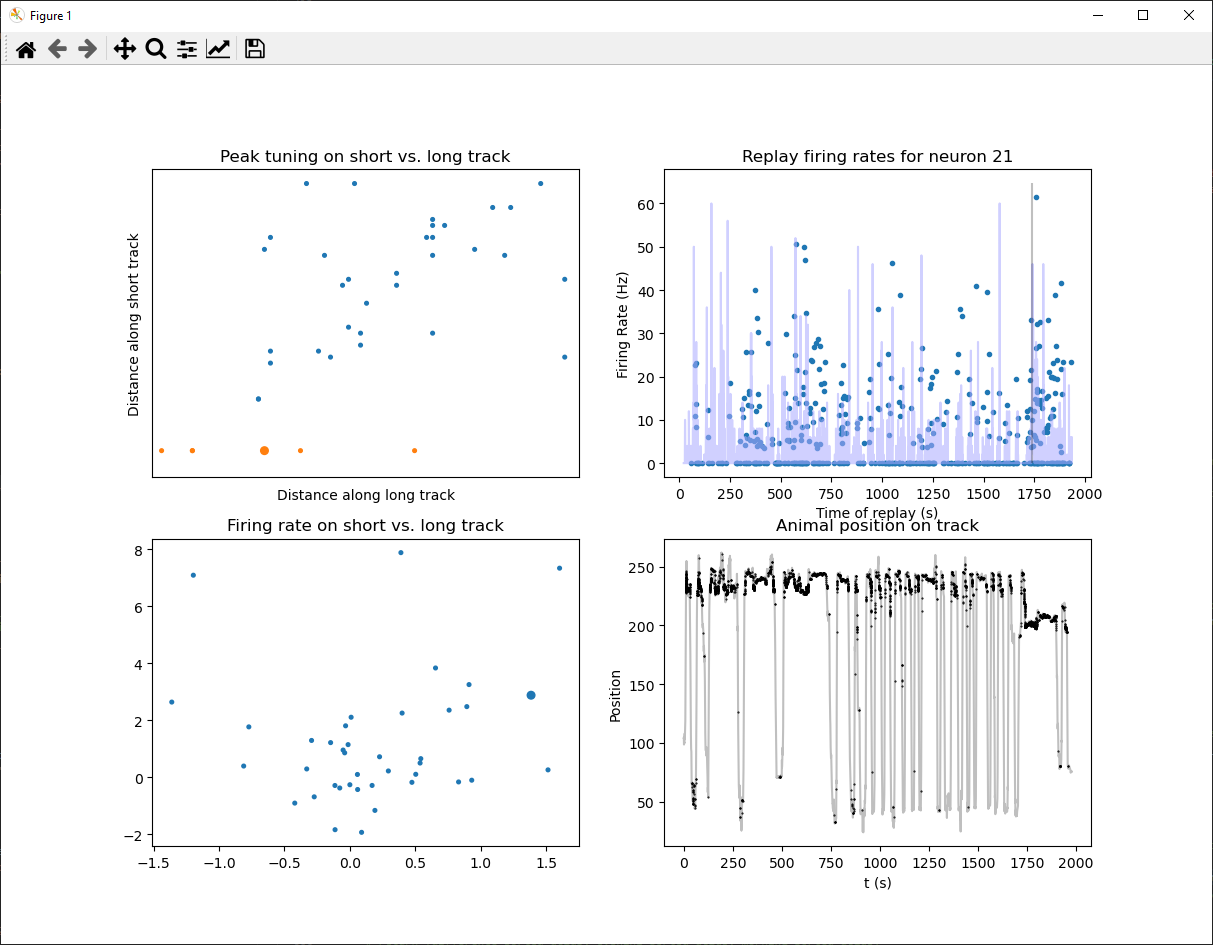

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx)
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
neuron_replay_stats_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
axs

In [ ]:
computation_result = curr_active_pipeline.computation_results['maze_PYR']
sess = computation_result.sess
computed_data = computation_result.computed_data
pf1D_all = computed_data.pf1D

In [ ]:
## Loop through and programmatically save out the interactive Jonathan firing rate figures:
on_index_change_callback, g_index = graphics_output_dict['on_index_change']['callback'], graphics_output_dict['on_index_change']['g_index']
curr_sess_ctx = curr_active_pipeline.sess.get_context()

g_index = 0
for i in np.arange(neuron_replay_stats_df.shape[0]):
    g_index = i
    aclu = neuron_replay_stats_df.index[i]
    curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclu=aclu)
    on_index_change_callback(g_index)
    
    curr_output_name = f'{curr_ctx.get_description()}'
    print(f'i: {i}, aclu: {aclu}, curr_output_name: {curr_output_name}')
    fig.savefig(fname=curr_output_name)

## 🗨️🟢 2022-11-05 - Pho-Jonathan Batch Outputs of Firing Rate Figures

In [ ]:
# %pdb on
# %pdb off
# %%viztracer
%matplotlib qt

## 2022-11-28 - Custom Scatterplot Markers that are filled proportionally to the number of num_long_only_neuron_participating to num_short_only_neuron_participating
neuron_type_distribution_color_scalar:
    -1.0 (long_only, 'red') -> 1.0 (short_only, 'blue')

#### Screenshots

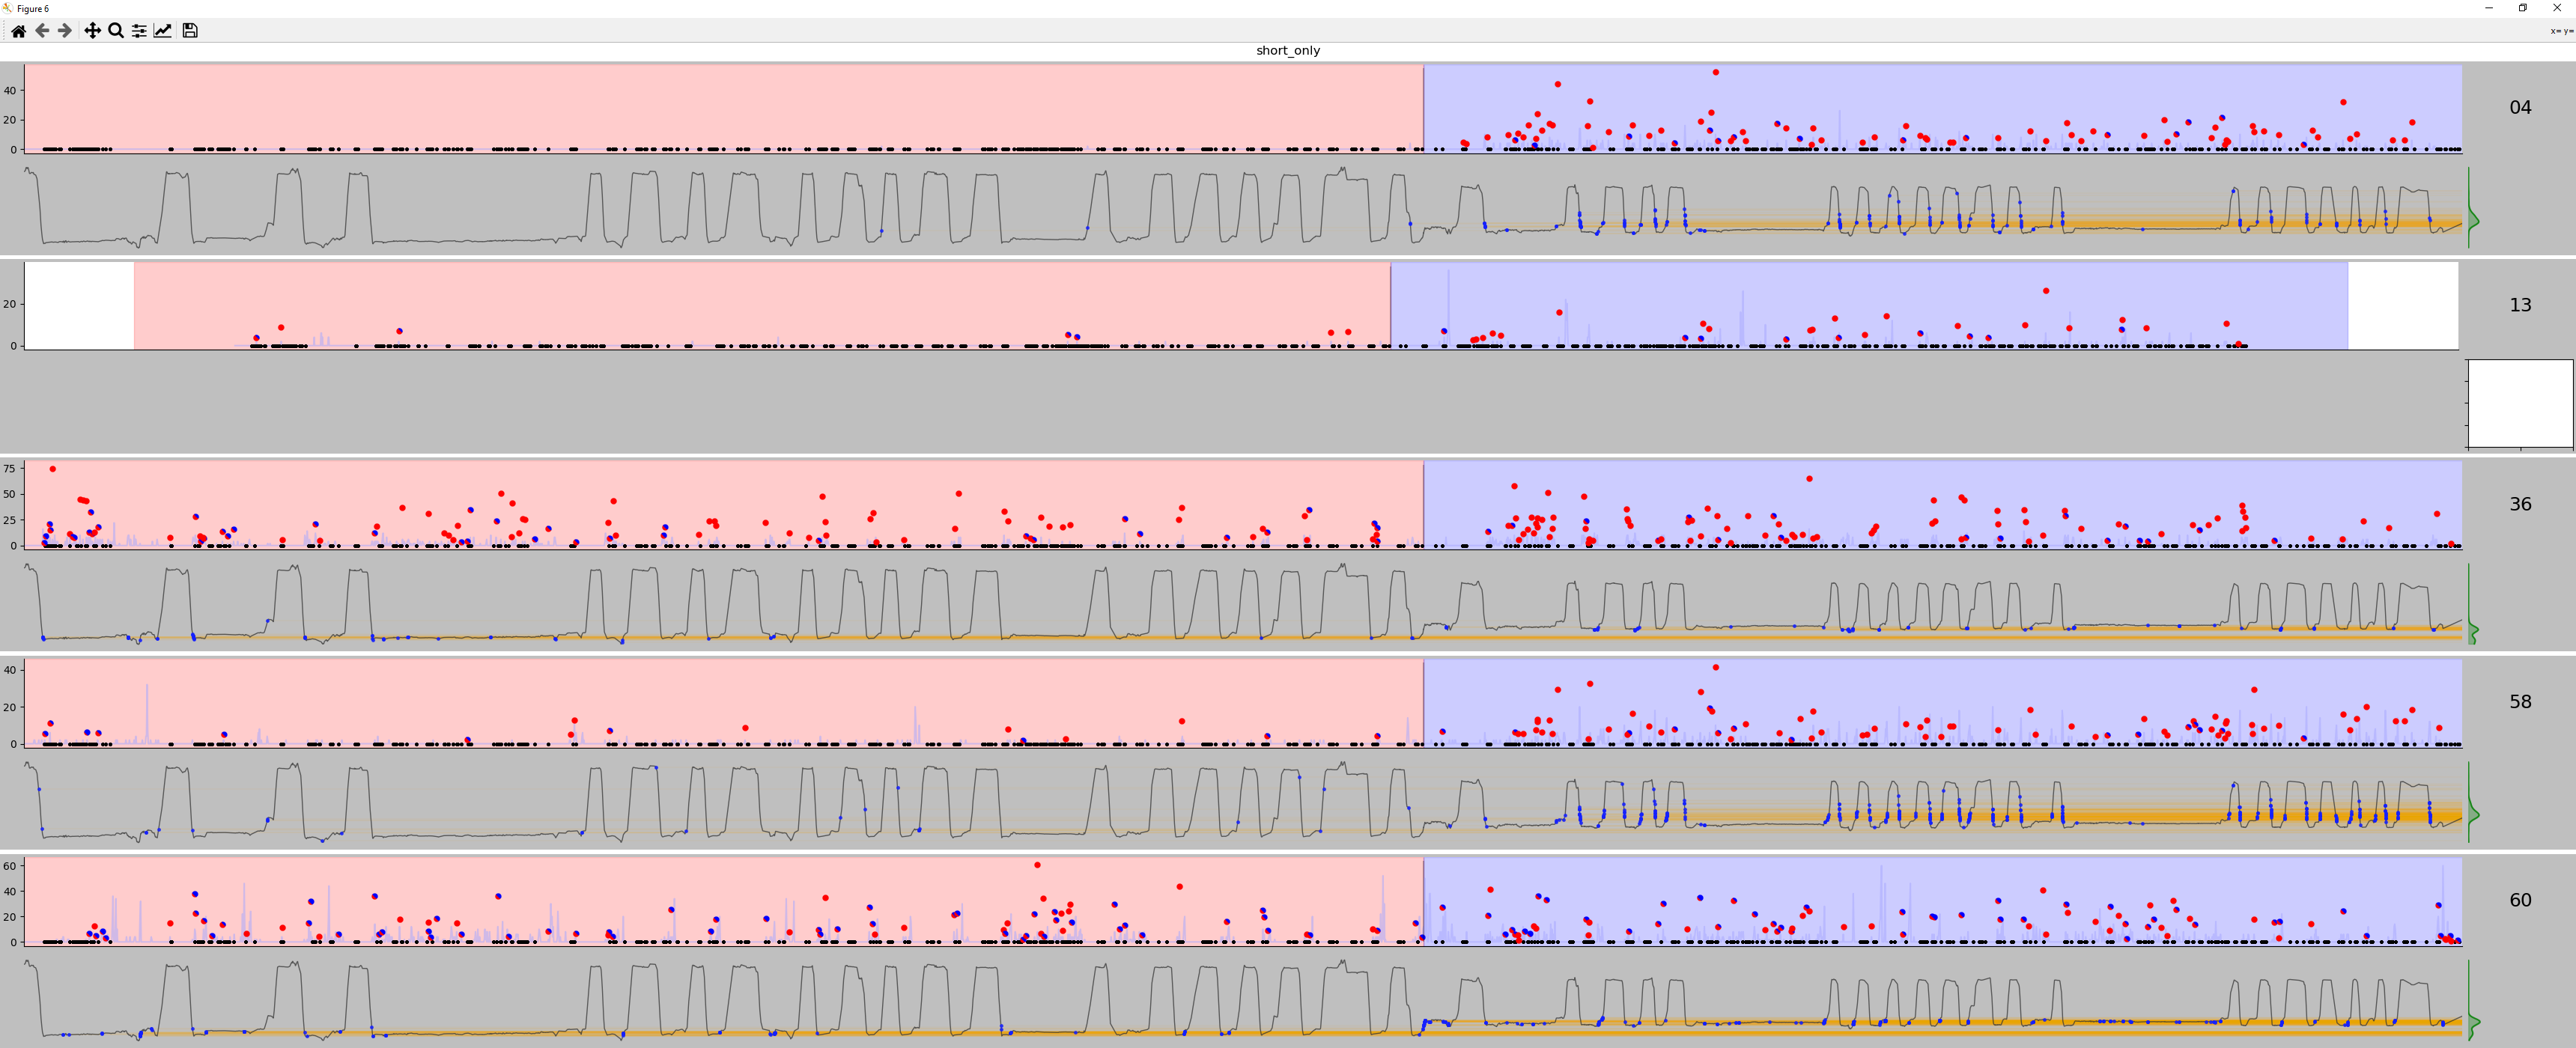

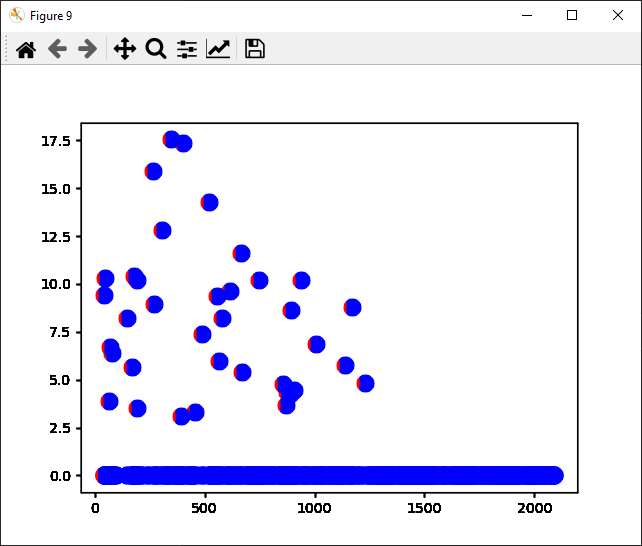
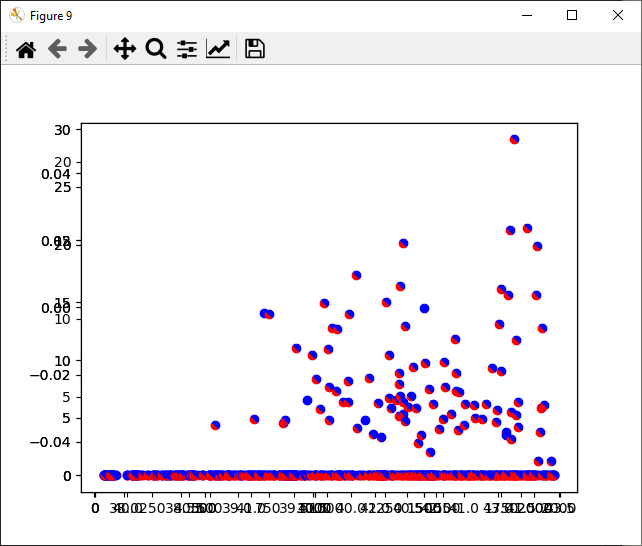

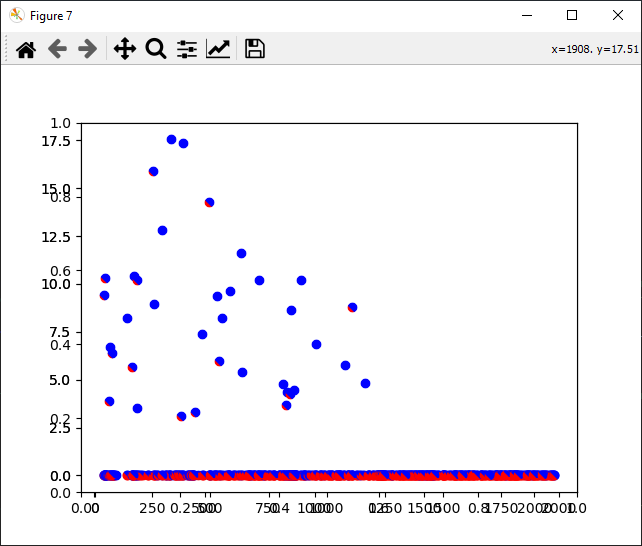
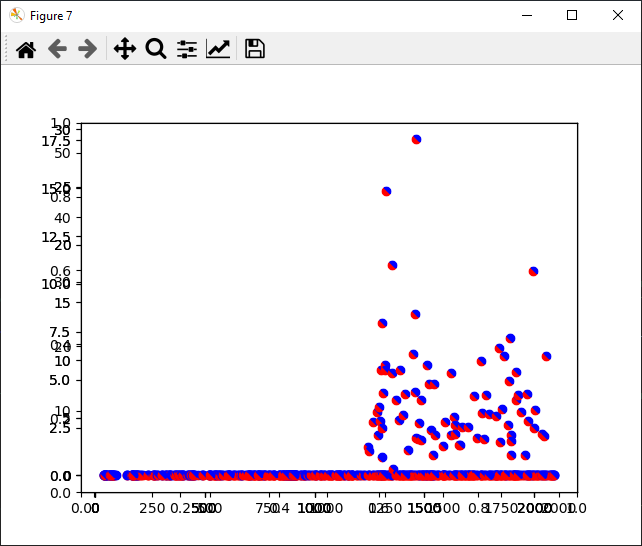

#### `_display_batch_pho_jonathan_replay_firing_rate_comparison` call

## NEWEST

In [ ]:
# %matplotlib qtagg
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')

In [ ]:
# backend_qt5agg
matplotlib.use('AGG') # non-interactive backend ## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!

In [ ]:
from PendingNotebookCode import _perform_batch_plot, _build_batch_plot_kwargs

# ==================================================================================================================== #
# Output Figures to File                                                                                               #
# ==================================================================================================================== #

n_max_page_rows = 10
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
active_identifying_session_ctx.get_description()
_batch_plot_kwargs_list = _build_batch_plot_kwargs(long_only_aclus, short_only_aclus, shared_aclus, active_identifying_session_ctx, n_max_page_rows=n_max_page_rows)
active_out_figures_list = _perform_batch_plot(curr_active_pipeline, _batch_plot_kwargs_list, figures_parent_out_path=None, write_pdf=False, write_png=True, progress_print=True, debug_print=False)

## Pre 2022-11-30 Batch Plotting Format

In [ ]:
## Single `_display_batch_pho_jonathan_replay_firing_rate_comparison` Plot Command:

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# included_unit_neuron_IDs=[2, 8, 16, 105, 109] # long-only
# included_unit_neuron_IDs = long_only_aclus
# fignum='long_only'

# included_unit_neuron_IDs=[ 4, 13, 36, 58, 60] # short-only
included_unit_neuron_IDs = short_only_aclus
# fignum='short_only'

# included_unit_neuron_IDs=difference_sorted_aclus[:8] # get the first 8 difference-sorted aclus
# included_unit_neuron_IDs=difference_sorted_aclus[-8:] # get the last 8 difference-sorted aclus

# included_unit_neuron_IDs = None
fignum=None
# included_unit_neuron_IDs = difference_sorted_result.sorted_aclus
# included_unit_neuron_IDs = difference_sorted_result.sorted_aclus[:10]
# included_unit_neuron_IDs = difference_sorted_result.sorted_aclus[::-1][:10] # reverse

graphics_output_dict = curr_active_pipeline.display('_display_batch_pho_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx,
                                                    n_max_plot_rows=10, included_unit_neuron_IDs=included_unit_neuron_IDs,
                                                    show_inter_replay_frs=False, spikes_color=(0.1, 0.0, 0.1), spikes_alpha=0.5, fignum=fignum)
fig, subfigs, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['subfigs'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
# Extract plot_data:
neuron_replay_stats_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
time_bins, time_binned_unit_specific_binned_spike_rate = plot_data['time_binned_unit_specific_spike_rate']['time_bins'], plot_data['time_binned_unit_specific_spike_rate']['time_binned_unit_specific_binned_spike_rate']
# axs

# plt.suptitle(fignum)

In [ ]:
# Shared Cells
curr_display_function_name = '_display_batch_pho_jonathan_replay_firing_rate_comparison_SHARED'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    plots = [] # empty list to hold figures
    for i, curr_batch_plot_kwargs in enumerate(paginated_shared_cells_kwarg_list):
        a_fig = _batch_plot_test(**curr_batch_plot_kwargs)
        plots.append(a_fig)
        
    # # plt.ion()
    for fig_idx, a_fig in enumerate(plots):
        print(f'saving fig: {fig_idx+1}/{len(plots)}')
        pdf.savefig(a_fig)
        # pdf.attach_note(f'Page {fig_idx + 1}')
        # pdf.savefig(a_fig, transparent=True)
    # When no figure is specified the current figure is saved
    # pdf.savefig()
        
print(f'saved to {curr_pdf_save_path}')

In [ ]:
active_aclu = 4
is_aclu_active_in_replay = np.array([active_aclu in replay_active_aclus for replay_active_aclus in rdf.active_aclus]) # .shape (743,)
rdf[is_aclu_active_in_replay]

In [ ]:
neuron_replay_stats_df[neuron_replay_stats_df.index == active_aclu] # indicates that it's short-only

In [ ]:
neuron_replay_stats_df

### Other Plotting Examples/Testing

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Create Map
cmap = plt.get_cmap('PiYG')
# cmap = LinearSegmentedColormap.from_list("", [(1, 0, 0), (0, 0, 1)]) # map between these two colors

cmap

In [ ]:
rgba = cmap(0.5)
rgba

In [ ]:

cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
scalarMap.to_rgba(cs)

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'
import pandas as pd

df = px.data.tips()

df = rdf


active_aclu = 2
fig = px.scatter(df, x=(rdf["start"] + rdf["end"])/2, y=make_fr(rdf)[:, aclu_to_idx[active_aclu]], log_x=False, size_max=100, color="num_long_only_neuron_participating") # , text="country"
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Life Expectency', title_x=0.5)
fig.show()

# fig = px.scatter(df, x="gdpPercap", y="lifeExp", text="country", log_x=True, size_max=100, color="lifeExp")
# fig.update_traces(textposition='top center')
# fig.update_layout(title_text='Life Expectency', title_x=0.5)
# fig.show()

In [ ]:
# This is in PIXELS
# first tuple : coords of box' bottom-left corner, from the figure's bottom-left corner
# second tuple : coords of box' top-right corner, from the figure's bottom-left corner
clip_box = Bbox(((0,0),(0.5, 1.0)))
# circle = Circle((0,0),1)

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
cut_star = mpath.Path(
    vertices=np.concatenate([circle.vertices, star.vertices[::-1, ...]]),
    codes=np.concatenate([circle.codes, star.codes]))

In [ ]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.show()

In [ ]:
"""
============================
Circles, Wedges and Polygons
============================
"""

import numpy as np
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

resolution = 50  # the number of vertices
N = 3
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r)
    patches.append(circle)

x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
theta1 = 360.0*np.random.rand(N)
theta2 = 360.0*np.random.rand(N)
for x1, y1, r, t1, t2 in zip(x, y, radii, theta1, theta2):
    wedge = Wedge((x1, y1), r, t1, t2)
    patches.append(wedge)

# Some limiting conditions on Wedge
patches += [
    Wedge((.3, .7), .1, 0, 360),             # Full circle
    Wedge((.7, .8), .2, 0, 360, width=0.05),  # Full ring
    Wedge((.8, .3), .2, 0, 45),              # Full sector
    Wedge((.8, .3), .2, 45, 90, width=0.10),  # Ring sector
]

for i in range(N):
    polygon = Polygon(np.random.rand(N, 2), True)
    patches.append(polygon)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)

plt.show()

In [ ]:
fig.show()

In [ ]:
curr_sess_ctx = curr_active_pipeline.sess.get_context()
# curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclus=aclu)
curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', display_function='display_batch_pho_jonathan_replay_firing_rate_comparison')
curr_output_name = f'{curr_ctx.get_description()}'
print(f'curr_output_name: {curr_output_name}')
fig.savefig(fname=curr_output_name)



In [ ]:
curr_sess_ctx = curr_active_pipeline.sess.get_context()

g_index = 0
for i in np.arange(neuron_replay_stats_df.shape[0]):
    g_index = i
    aclu = neuron_replay_stats_df.index[i]
    curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclu=aclu)
    curr_subfig = subfigs[i]
    curr_output_name = f'{curr_ctx.get_description()}'
    print(f'i: {i}, aclu: {aclu}, curr_output_name: {curr_output_name}')
    curr_subfig.savefig(fname=curr_output_name)

In [ ]:
curr_axs_dict = axs[0]
curr_firing_rate_ax, curr_lap_spikes_ax, curr_placefield_ax = curr_axs_dict['firing_rate'], curr_axs_dict['lap_spikes'], curr_axs_dict['placefield'] # Extract variables from the `curr_axs_dict` dictionary to the local workspace

## 🗨️ 2022-10-31 - Laps and Periods Overview

In [ ]:
curr_active_pipeline.sess.laps

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
# Complete Version:
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)

In [ ]:
# Paginated Version:
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=0)
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=1)

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
# %pdb on
p, laps_pages = plot_lap_trajectories_3d(curr_active_pipeline.sess, single_combined_plot=False, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)
p.show()

In [ ]:
# This one works:
p, laps_pages = plot_lap_trajectories_3d(curr_active_pipeline.sess, single_combined_plot=True)
p.show() 

In [ ]:
curr_camera = p[0, 0].camera
curr_camera

In [ ]:
curr_camera.elevation

In [ ]:
curr_camera.position

In [ ]:
p[0, 0].set_background('black') #.set_background('black', top='white')
p[0, 0].camera_position = 'yz'
p[0, 0].camera.elevation = 45

In [ ]:
p[0, 0].enable_parallel_projection()
p[0, 0].camera.tight()

In [ ]:
new_ripple_df = pd.read_pickle(r'W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\ripple_df.pkl')
new_ripple_df

In [ ]:
from neuropy.core.flattened_spiketrains import safe_pandas_get_group
# curr_active_pipeline.sess.

unique_shank_ids = np.unique(curr_active_pipeline.sess.neurons.shank_ids)
cell_info_df = pd.DataFrame({'shank_id': curr_active_pipeline.sess.neurons.shank_ids, 'neuron_id': curr_active_pipeline.sess.neurons.neuron_ids, 'neuron_type': curr_active_pipeline.sess.neurons.neuron_type})
# cell_info_df
shank_split_cell_info_dfs = [safe_pandas_get_group(cell_info_df.groupby('shank_id'), shank_id).neuron_id.to_numpy().tolist()[:4] for shank_id in unique_shank_ids] # dataframes split for each ID
shank_split_cell_info_dfs

print(f'unique_shank_ids: {unique_shank_ids}')
print(f'shank_split_channel_idxs: {shank_split_cell_info_dfs}')

# unique_shank_ids: [1 2 3 4 8 9 10 12]
# shank_split_channel_idxs: [[2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [19, 20, 21, 22], [23, 24, 25], [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], [56, 57, 58, 59, 60]]

## 🟢 2022-11-21 - Modern Aggregate Stats

In [ ]:
# Now compute for the individual cells:
neuron_replay_stats_df

In [ ]:
sorted_neuron_replay_stats_df = neuron_replay_stats_df.reindex(difference_sorted_aclus).copy() # This seems to work to re-sort the dataframe by the sort indicies
sorted_neuron_replay_stats_df

In [ ]:
sorted_aclus = sorted_neuron_replay_stats_df.index.to_numpy()
sorted_aclus


In [ ]:
long_results.pf1D.bin_info # {'mode': 'bin_size', 'xstep': 3.793023081021702, 'xnum_bins': 64}

In [ ]:
short_results.pf1D.bin_info # {'mode': 'bin_size', 'xstep': 3.793023081021702, 'xnum_bins': 41}

In [ ]:
long_results.pf1D.plot_ratemaps_1D(sortby='id', fignum=2)

## Convolution/Comparison-based methods
https://stackoverflow.com/questions/48285417/understanding-scipy-convolution


In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import _test_plot_conv

short_xbins = short_results.pf1D.xbin_centers # .shape # (40,)
# short_curves = short_results.pf1D.ratemap.tuning_curves # .shape # (64, 40)
short_curves = short_results.pf1D.ratemap.normalized_tuning_curves # .shape # (64, 40)

long_xbins = long_results.pf1D.xbin_centers # .shape # (63,)
# long_curves = long_results.pf1D.ratemap.tuning_curves # .shape # (64, 63)
long_curves = long_results.pf1D.ratemap.normalized_tuning_curves # .shape # (64, 63)

short_long_pf_overlap_analyses = curr_active_pipeline.global_computation_results.computed_data.short_long_pf_overlap_analyses
conv_overlap_dict = short_long_pf_overlap_analyses['conv_overlap_dict']
prod_overlap_dict = short_long_pf_overlap_analyses['product_overlap_dict']

pf_overlap_conv_results = []
# for i, a_pair in enumerate(pf_neurons_diff.shared.pairs):
i = 5
curr_aclu = pf_neurons_diff.either[i]
a_pair = pf_neurons_diff.shared.pairs[i]
long_idx, short_idx = a_pair
if long_idx is None or short_idx is None:
    # missing entry, answer is zero
    overlap_results_dict = None
else:        
    curr_cell_valid_subset = list(conv_overlap_dict.values())[i]['valid_subset']
    # curr_cell_valid_subset = list(conv_overlap_dict.values())[i]['full']
    x, convolved_result, normalized_convolved_result, area = curr_cell_valid_subset['x'], curr_cell_valid_subset['convolved_result'], curr_cell_valid_subset['normalized_convolved_result'], curr_cell_valid_subset['area']
    
    curr_cell_prod_overlap = list(prod_overlap_dict.values())[i] 
    prod_x, prod_overlap_dot_product, prod_normalized_overlap_dot_product, prod_area, prod_peak_max, prod_extrapolated_short_curve = curr_cell_prod_overlap['x'], curr_cell_prod_overlap['overlap_dot_product'], curr_cell_prod_overlap['normalized_overlap_dot_product'], curr_cell_prod_overlap['area'], curr_cell_prod_overlap['peak_max'], curr_cell_prod_overlap['extrapolated_short_curve'] # Extract variables from the `curr_cell_prod_overlap` dictionary to the local workspace

    long_curve = long_curves[long_idx]
    short_curve = short_curves[short_idx]
        
    overlap_result = {'conv': normalized_convolved_result, 'dot_product': prod_overlap_dot_product}
    overlap_results_dict = _test_plot_conv(long_xbins, long_curve, short_xbins, short_curve, x, overlap_result)
    overlap_results_dict.figures.suptitle(f'aclu: {curr_aclu} - overlap_area: {area}')
pf_overlap_conv_results.append(overlap_results_dict)


pf_overlap_conv_results

In [ ]:
conv_overlap_scalars_df = short_long_pf_overlap_analyses['conv_overlap_scalars_df']
conv_overlap_scalars_df

### NOTE: end of day 2022-11-22 - t_full_subset and m_full_subset contain the computed convolution for a single cell (with index i), but I'm not sure how useful this is. It does NOT seem to be a measure of the overlap at all.
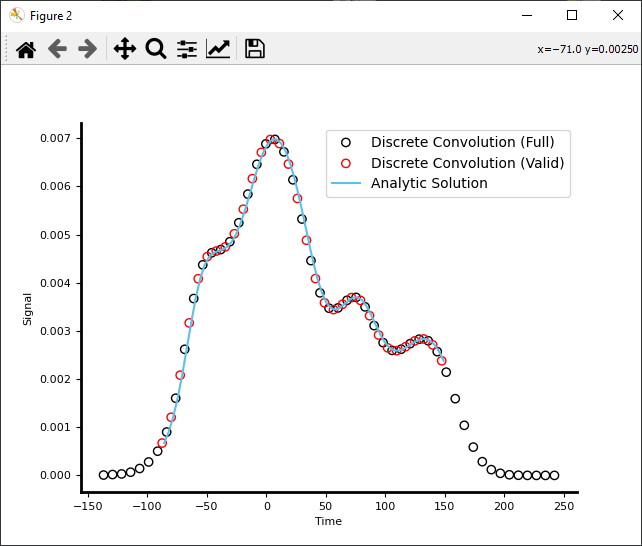
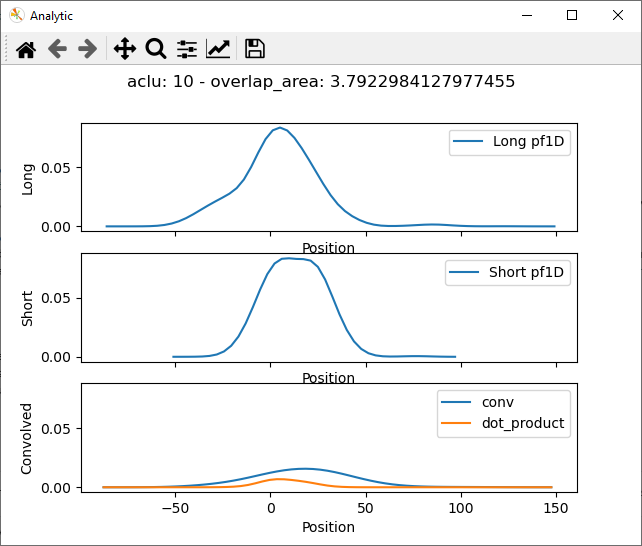

## 2022-11-22 - Quantifying Surprise
http://ilab.usc.edu/surprise/

Can we compare the difference of the time-dependent placefield before and after an observation to see the surpise the observation confirs? This is different than the other thing.

In [ ]:
# num_replays
# avg_replay_firing_rate
# avg_non_replay_firing_rate
# max/min/mean/range firing_rate

## Other things to look at:

-> Simple: https://stackoverflow.com/questions/65879014/align-overlap-two-vectors-that-are-slightly-shifted

-> Shapely library method: https://stackoverflow.com/questions/64033576/finding-the-area-of-an-overlap-between-curves-python

https://math.stackexchange.com/questions/2404750/intersection-normal-distributions-and-minimal-decision-error/2435957#2435957
https://journals.lww.com/epidem/Fulltext/2005/01000/Optimal_Cut_point_and_Its_Corresponding_Youden.11.aspx

-> Promising: https://stackoverflow.com/questions/64033576/finding-the-area-of-an-overlap-between-curves-python
    https://en.wikipedia.org/wiki/Green%27s_theorem
    https://en.wikipedia.org/wiki/Planimeter
    http://paulbourke.net/geometry/polygonmesh/




## 🟢 2022-11-21 - 1D Ratemaps Before and After Track change (Long vs. Short track)
Working metrics for comparing overlaps of 1D placefields before and after track change

![image.png](attachment:21aa1dda-9c61-4acf-9d61-028b52e0d1e8.png)
![python_PbL1Fl33Hc.png](attachment:23c00e7b-ef9f-4379-bbed-269dacb36e54.png)


In [ ]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons, _compare_computation_results
from neuropy.utils.colors_util import get_neuron_colors
from neuropy.core.neuron_identities import PlotStringBrevityModeEnum
from neuropy.plotting.figure import Fig
from neuropy.plotting.ratemaps import plot_ratemap_1D

from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import build_neurons_color_map

long_results = curr_active_pipeline.computation_results['maze1_PYR'].computed_data
short_results = curr_active_pipeline.computation_results['maze2_PYR'].computed_data
all_results = curr_active_pipeline.computation_results['maze_PYR'].computed_data

# get shared neuron info:
pf_neurons_diff = _compare_computation_results(long_results.pf1D.ratemap.neuron_ids, short_results.pf1D.ratemap.neuron_ids)
curr_any_context_neurons = pf_neurons_diff.either
long_only_aclus = pf_neurons_diff.lhs_only
short_only_aclus = pf_neurons_diff.rhs_only
print(f'long_only_aclus: {long_only_aclus}\nshort_only_aclus: {short_only_aclus}')
n_neurons = pf_neurons_diff.shared.n_neurons
shared_fragile_neuron_IDXs = pf_neurons_diff.shared.shared_fragile_neuron_IDXs

neurons_colors_array = build_neurons_color_map(n_neurons, sortby=shared_fragile_neuron_IDXs, cmap=None)

sort_idx = shared_fragile_neuron_IDXs.copy()    
print(f'n_neurons: {n_neurons}')
print(f'shared_fragile_neuron_IDXs: {shared_fragile_neuron_IDXs}.\t np.shape: {np.shape(shared_fragile_neuron_IDXs)}')
print(f'curr_any_context_neurons: {curr_any_context_neurons}.\t np.shape: {np.shape(curr_any_context_neurons)}')

## Github-style activity plot for each cell's group

In [ ]:
#Importing the seaborn library along with other dependencies
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)
sns.set_theme()

uniform_data = np.random.rand(15, 20)
ax = sns.heatmap(uniform_data, cmap="YlGnBu")
# import datetime as dt
# from datetime import datetime
# Creating new features from the data
# data['year'] = data.date_time.dt.year
# data['month'] = data.date_time.dt.month
# data['Weekday'] = data.date_time.dt.day_name()
# plt.figure(figsize = (16,6))
# sns.heatmap(pivoted_data, linewidths=5, cmap='YlGn',linecolor='white', square=True)

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership

cell_aclu_labels = [f'{aclu}' for aclu in pf_neurons_diff.either]
cell_membership_array = np.concatenate([np.full_like(pf_neurons_diff.lhs_only, SplitPartitionMembership.LEFT_ONLY.value),
    np.full_like(pf_neurons_diff.intersection, SplitPartitionMembership.SHARED.value),
    np.full_like(pf_neurons_diff.rhs_only, SplitPartitionMembership.RIGHT_ONLY.value)])

In [ ]:
cell_aclu_labels

In [ ]:
ax = sns.heatmap(cell_membership_array, cmap="YlGnBu")

In [ ]:
# see https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 8.0
# labelizer = lambda k: {('a',): 'first', ('b',): 'second', ('c',): 'third'}[k]
# labelizer = lambda k: {(SplitPartitionMembership.LEFT_ONLY,): 'first', ('b',): 'second', ('c',): 'third'}[k]
# mosaic(neuron_replay_stats_df, ['neuron_IDX', 'track_membership'], title='Neuron Pf1D Membership');
mosaic(neuron_replay_stats_df, ['track_membership', 'neuron_IDX'], title='Neuron Pf1D Membership'); # , labelizer=labelizer

In [ ]:
[neuron_replay_stats_df.track_membership

## Resume

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
short_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.RIGHT_ONLY]
print(f'short_only_aclus: {short_only_df.index.values.tolist()}')
long_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.LEFT_ONLY]
print(f'long_only_aclus: {long_only_df.index.values.tolist()}')

In [ ]:
long_only_df.index.values

# ❌ Day 0 (idxing at 0) 
Error because the short-track measurement was cut-off. Session cannot be used, which is too bad because it's the first exposure to each track.

# 🥅 Day 1 (idxing at 0)
long_only_aclus: [2, 8, 16, 105, 109]
short_only_aclus: [4, 13, 36, 58, 60]

## 🥅🔬7️⃣👁‍🗨 Observations for short-only cells:
For short_only cells: [4, 13, 36, 58, 60]

`short_num_replays`:
    - long_only_dfCells [4, 13, 58] have substantially more replays on the short track
    - Cells 36 and 60 actually have more replays on the long track despite not having a placefield on that track
    

## 🥅🔬7️⃣👁‍🗨 Observations for long-only cells:
For long_only cells: [2, 8, 16, 105, 109]

`long_num_replays`:
    - long_only cells [2, 16, 109] have substantially more replays on the long track
    - Cells [8, 105] actually have more replays on the short track despite not having a placefield on that track
        - ❓ are these replays of the long track during the short track - e.g. are the other cells in these replays all long_only?
            -> Many of them appear to be long_only replays
        - Cell 8 - appears to maintain its placefield from the long-track on the short track completely intact, the animal just doesn't go there because it's at the very edge of the arena once shortened
        - Cell 105 - does not have a valid global_epoch placefield either, probably can be thrown out.
        
        ✳️🔜look at all replays on the short track containing these two cells - they should comtrain no short only cells because they are replays of the long track (hypothesis)
            -> 🥅 looks like 9/19 replays on the long track (prior to switch) contain at least one short_only cell (violating hypothesis) -> perhaps pre-play
                The remaining 10/19 are pure long-only replays as would be expected (consistent with hypothesis)

# 🥅 Day 2 (idxing at 0)
long_only_aclus: [45] 
    - 45 - nearly all replays it's involved in (on both tracks) involve only long cells.
    
short_only_aclus: [62]
    - 62 - nearly all replays it's involved in (on both tracks) involve only short cells
        - it does appear prior to switch -- preplay?

❓📌⛳ Should I be comparing the cell's replay firing rate to its surrounding non-replay firing rates?
    - makes sense to rule out irrelevant activity during replay that's not any different from its previous activity
    - in contrast, cell firing during a proper replay involving it are expected to be about the same firing rate as its position on the track, meaning if we baselined with this we'd subtract out that activity (incorrectly)
    
    => 📌 Again, it seems like we need to look at the *likelihood that a given replay firing is generated by chance (spuriously) by taking into account the expected firing at the animal's current location*
    

# ❌ Day 3 (idxing at 0) - needs to build rebuilt without pickle

# 🥅 Day 4 (idxing at 0)
long_only_aclus: [] 
    
short_only_aclus: [33]
    - 33 - all replays it's involved in (on both tracks) involve only short cells
        - it does appear prior to switch -- preplay?
        - the placefield is very dispursed despite being consistent

# Other

In [ ]:
long_only_df.long_num_replays > long_only_df.short_num_replays

In [ ]:
global_epoch_name = 'maze_PYR'
sess = curr_active_pipeline.filtered_sessions[global_epoch_name] # get the filtered session with the global_epoch_name (which we assert exists!)
replays_df = sess.replay

In [ ]:
sess.n_neurons # 40

In [ ]:
len(aclu_to_idx)

In [ ]:
all_cell_ids = np.array(list(aclu_to_idx.keys()))
all_cell_ids

In [ ]:
final_global_neuron_IDs = curr_active_pipeline.filtered_sessions['maze_PYR'].neuron_ids.copy() # .shape # (40,)
final_global_neuron_IDs

In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

long_single_cell_pfmap_processing_fn = None
short_single_cell_pfmap_processing_fn = None

# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: 0.5 * pfmap # flip over the y-axis
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: -0.5 * pfmap # flip over the y-axis

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # flip over the y-axis, shift the baseline down by half


# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (1.0 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-1.0 * pfmap * pad) + (1.0*pad) # this does not work and results in short being fully filled. I think this is because the fill_between gets reversed since everything is below baseline


out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=True, debug_print=False, fignum='Short v Long pf1D Comparison',
                                   long_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
                                   short_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
                                  )
ax = out.axes[0]

In [ ]:
## Overlap Scalar Comparisons: plots a comparison of a specific type of scalar values for all cells
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import PlacefieldOverlapMetricMode

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# overlap_metric_mode = PlacefieldOverlapMetricMode.POLY
overlap_metric_mode = PlacefieldOverlapMetricMode.PRODUCT
# overlap_metric_mode = PlacefieldOverlapMetricMode.CONVOLUTION

out = curr_active_pipeline.display('_display_short_long_pf1D_scalar_overlap_comparison', active_identifying_session_ctx, overlap_metric_mode=overlap_metric_mode, variant_name='_area')

In [ ]:
## Test sorting the neurons by the scalar comparison quantities:
short_long_pf_overlap_analyses_results = curr_active_pipeline.global_computation_results['computed_data']['short_long_pf_overlap_analyses']
pf_neurons_diff = short_long_pf_overlap_analyses_results['short_long_neurons_diff'] # get shared neuron info:
n_neurons = pf_neurons_diff.shared.n_neurons
shared_fragile_neuron_IDXs = pf_neurons_diff.shared.shared_fragile_neuron_IDXs
# neurons_colors_array = build_neurons_color_map(n_neurons, sortby=shared_fragile_neuron_IDXs, cmap=None)

prod_overlap_dict = short_long_pf_overlap_analyses_results['product_overlap_dict']
product_overlap_scalars_df = short_long_pf_overlap_analyses_results['product_overlap_scalars_df']

In [ ]:
short_long_pf_overlap_analyses_results.short_long_neurons_diff

In [ ]:
product_overlap_scalars_df

In [ ]:
aclus = product_overlap_scalars_df.index.to_numpy()
aclus

In [ ]:
sort_non_common_last = True # if True, the non-common (neurons unique to one of the two epochs) are sorted after all of the others


In [ ]:
product_overlap_scalars_df.sort_values(by='prod_overlap', ascending=False)

In [ ]:
sort_idx = np.argsort(product_overlap_scalars_df.prod_overlap.to_numpy())[::-1] # the `[::-1]` term reverses the array, which by defaul is returned in ascending order and we want descending
sort_idx

# Use the thingy
Look at the stuffs! Okay DUDE!
Calling fig.show() makes the figures show up, but they don't show up naturally :[


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.MultiContextComputationFunctions import _compute_neuron_replay_stats, FiringRateActivitySource, compute_evening_morning_parition, SortOrderMetric, _compute_modern_aggregate_short_long_replay_stats

evening_morning_parition_dict = compute_evening_morning_parition(neuron_replay_stats_df, firing_rates_activity_source=FiringRateActivitySource.BOTH, debug_print=False)
evening_morning_parition_dict

difference_sorted_result = evening_morning_parition_dict['diff']
difference_sorted_result

In [ ]:
(diff_total_num_replays, diff_total_replay_duration, diff_mean_replay_duration, diff_var_replay_duration), (long_total_num_replays, long_total_replay_duration, long_mean_replay_duration, long_var_replay_duration), (short_total_num_replays, short_total_replay_duration, short_mean_replay_duration, short_var_replay_duration) = _compute_modern_aggregate_short_long_replay_stats(rdf)

In [ ]:
rdf

# 2022-11-29 - Properly getting all the spikes:
Currently the spikes plotted on the activity/animal position 1D plot are those included in the placefield 1D, as they're plotted with `plot_1D_placecell_validation` -> `pf1D..plotRaw_v_time(...)`. 

In [ ]:
curr_aclu_axs = axs[-2]
ax_activity_v_time = curr_aclu_axs['lap_spikes']
ax_activity_v_time

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import _plot_general_all_spikes, _build_spikes_df_interpolated_props

cell_grouped_spikes_df, cell_spikes_dfs = _build_spikes_df_interpolated_props(global_results)

In [ ]:
active_aclu = 105

# active_spikes_df = cell_grouped_spikes_df.get_group(active_aclu) # alternative that doesn't need cellind at all. Actually, this DOES NOT WORK because it's not the updated dataframe
# active_spikes_df

cellind = aclu_to_idx[active_aclu]
active_spikes_df = cell_spikes_dfs[cellind]
active_spikes_df

ax_activity_v_time.clear()
ax_activity_v_time = _plot_general_all_spikes(ax_activity_v_time, active_spikes_df, time_variable_name=global_results.sess.spikes_df.spikes.time_variable_name, defer_render=False)

In [ ]:
active_spikes_df

In [ ]:
# fig = ax_activity_v_time.get_figure().get_figure()
fig = ax_activity_v_time.get_figure().get_figure() # For SubFigure
fig.canvas.draw()

In [ ]:
fig.get_figure()

In [ ]:
np.isin(long_results.sess.spikes_df.index, long_results.computed_data.pf1D.filtered_spikes_df.index) #.shape # (66404,)

In [ ]:
long_results.sess.spikes_df['is_included_long_pf1D'] = False
long_results.sess.spikes_df.loc[np.isin(long_results.sess.spikes_df.index, long_results.computed_data.pf1D.filtered_spikes_df.index),'is_included_long_pf1D'] = True
long_results.sess.spikes_df

In [ ]:
short_results.sess.spikes_df

In [ ]:
global_results.sess.spikes_df

In [ ]:
global_epoch_name = 'maze_PYR'
sess = curr_active_pipeline.filtered_sessions[global_epoch_name] # get the filtered session with the global_epoch_name (which we assert exists!)
replays_df = sess.replay

In [ ]:
sess.n_neurons # 40

In [ ]:
len(aclu_to_idx)

In [ ]:
all_cell_ids = np.array(list(aclu_to_idx.keys()))
all_cell_ids

In [ ]:
final_global_neuron_IDs = curr_active_pipeline.filtered_sessions['maze_PYR'].neuron_ids.copy() # .shape # (40,)
final_global_neuron_IDs

# Automated Session Output Folder Hierarchy Creation (testing, unfinished)

In [ ]:
## PDF Output 
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed

local_session_names_list = ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']


# ### Animal `vvp01`:
# local_session_parent_path = Path(r'W:\Data\KDIBA\vvp01') # Apogee Windows (W: Wiser)

# local_session_names_list = ['2006-4-09_17-29-30',
#                             # '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6'
#                            ]


figures_parent_out_path = create_daily_programmatic_display_function_testing_folder_if_needed()
figures_parent_out_path

In [ ]:
session_save_paths_list = [figures_parent_out_path.joinpath(a_name).resolve() for a_name in local_session_names_list]
session_save_paths_list

for a_dir in session_save_paths_list:
    a_dir.mkdir(exist_ok=True)

In [ ]:
a_dir = session_save_paths_list[0]
a_dir


In [ ]:
basedir = local_session_paths_list[2] # NOT 3
print(f'basedir: {str(basedir)}')

In [ ]:
build_figure_basename_from_display_context(active_identifying_ctx, context_tuple_join_character='_')

In [ ]:
print(f'active_identifying_ctx: {active_identifying_ctx}')

In [ ]:
active_identifying_session_ctx.to_dict()

In [ ]:
curr_active_pipeline.active_sess_config

In [ ]:
format_names = ['kdiba']
animal_names = ['gor01']
number_names = ['one'] # 'two'
local_session_names_list = ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']



In [ ]:
[[] ]

for format_name in format_names:
    for animal_name in animal_names:
        for number_name in number_names:
            for session_name in local_session_names_list:
                

In [ ]:
('plot_result_set', 'page', 'aclus')

In [ ]:
active_identifying_ctx.get_description() # 'kdiba_2006-6-08_14-26-15_[4, 13, 36, 58, 60]'
[v['active_identifying_ctx'].get_description() for v in _batch_plot_kwargs_list]

In [ ]:
[v['active_identifying_ctx'].get_description() for v in paginated_shared_cells_kwarg_list]

In [ ]:
[[str(v) for v in list(v['active_identifying_ctx'].as_tuple())] for v in _batch_plot_kwargs_list]

In [ ]:
[[str(v) for v in list(v['active_identifying_ctx'].as_tuple())] for v in paginated_shared_cells_kwarg_list]

In [ ]:
_build_pdf_pages_output_info, programmatic_display_function_testing_output_parent_path = build_pdf_export_metadata(curr_active_pipeline.sess.get_description(), filter_name='global') # , filter_name='long_only'
print(f'Figure Output path: {str(programmatic_display_function_testing_output_parent_path)}')

In [ ]:
curr_fig_save_basename = build_figure_basename_from_display_context(active_identifying_ctx, context_tuple_join_character='_')
[f'{curr_fig_save_basename}{ext_str}' for ext_str in ('.png','.pdf')]

# ['kdiba_2006-6-09_1-22-43_batch_plot_test_long_only.png',
#  'kdiba_2006-6-09_1-22-43_batch_plot_test_long_only.pdf']